In [3]:
import pandas as pd
import numpy as np
from py_geohash_any import geohash as gh
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
#!/usr/bin/env python
from __future__ import print_function

import argparse
import random
import numpy as np
from collections import deque

import json
from collections import defaultdict
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Data Dictionary : Yellow Taxi Cab
- VendorID A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
- tpep_pickup_datetime The date and time when the meter was engaged.
- tpep_dropoff_datetime The date and time when the meter was disengaged.
- Passenger_count The number of passengers in the vehicle.
 This is a driver-entered value.
- Trip_distance The elapsed trip distance in miles reported by the taximeter.
- Pickup_longitude Longitude where the meter was engaged.
- Pickup_latitude Latitude where the meter was engaged.
- RateCodeID The final rate code in effect at the end of the trip.
 1= Standard rate 
 2=JFK
 3=Newark
 4=Nassau or Westchester
 5=Negotiated fare
 6=Group ride
- Store_and_fwd_flag This flag indicates whether the trip record was held in vehicle
 memory before sending to the vendor, aka “store and forward,”
 because the vehicle did not have a connection to the server.
- Y= store and forward trip
- N= not a store and forward trip
- Dropoff_longitude Longitude where the meter was disengaged.
- Dropoff_ latitude Latitude where the meter was disengaged.
- Payment_type A numeric code signifying how the passenger paid for the trip.
 1= Credit card
 2= Cash
 3= No charge
 4= Dispute
 5= Unknown
 6= Voided trip
- Fare_amount The time-and-distance fare calculated by the meter.
- Extra Miscellaneous extras and surcharges. Currently, this only includes
 t he 0.50 and 1 rush hour and overnight charges.
 M TA_tax 0.50 MTA tax that is automatically triggered based on the metered
 rate in use.
- Improvement_surcharge 0.30 improvement surcharge assessed trips at the flag drop. The
- improvement surcharge began being levied in 2015.
- Tip_amount Tip amount – This field is automatically populated for credit card
 tips. Cash tips are not included.
- Tolls_amount Total amount of all tolls paid in trip.
- Total_amount The total amount charged to passengers. Does not include cash tips.

### Geohash dictionary the distance between geohashes based on matching characters, in meters.
_PRECISION = {
    0: 20000000,
    1: 5003530,
    2: 625441,
    3: 123264,
    4: 19545,
    5: 3803,
    6: 610,
    7: 118,
    8: 19,
    9: 3.71,
    10: 0.6,
}

### Average speed of taxis in Manhattan
- In 2014, it dropped to 8.51 MPH. http://www.wnyc.org/story/traffic-speeds-slow-nyc-wants-curb-car-service-growth/
- 8.51 MPH is 3.80431 meters / second

### Geohash units are meters
- http://stackoverflow.com/questions/13448595/geohash-string-length-and-accuracy

In [4]:
#yellow_taxi_geohash_min_day
taxi_yellowcab_df = pd.read_csv("data/yellow_taxi_geohash_min_day.csv")

In [10]:
# Encoding error
taxi_yellowcab_df['geohash_dropoff']=taxi_yellowcab_df['geohas_dropoff']
#drop unnecessary columns
taxi_yellowcab_df.drop(['Unnamed: 0','Unnamed: 0.1'],inplace=True,axis=1)

In [11]:
taxi_yellowcab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10906858 entries, 0 to 10906857
Data columns (total 24 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
geohash_pickup           object
geohas_dropoff           object
jan_day                  int64
jan_minute               int64
geohash_dropoff          object
dtypes: float64(12), int64(6), object(6)
memory usage: 2.0+ GB


In [13]:
taxi_yellowcab_df.head(10)

,Unnamed: 0,Unnamed: 0.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff
0,0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,...,0.5,0.0,0.0,0.3,8.8,dr5rsr,dr5rsx,1,0,dr5rsx
1,1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,...,0.5,0.0,0.0,0.3,19.3,dr5rsw,dr5rtk,1,0,dr5rtk
2,2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,...,0.5,0.0,0.0,0.3,34.3,dr5rkm,dr72j1,1,0,dr72j1
3,3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,...,0.5,0.0,0.0,0.3,17.3,dr5rsh,dr5rkc,1,0,dr5rkc
4,4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,...,0.5,0.0,0.0,0.3,8.8,dr72hb,dr5rue,1,0,dr5rue
5,5,5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,...,0.5,0.0,0.0,0.3,20.3,dr5ru9,dr5ryh,1,18,dr5ryh
6,6,6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,...,0.5,0.0,0.0,0.3,27.3,dr5rsh,dr72hc,1,26,dr72hc
7,7,7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,...,0.5,0.0,0.0,0.3,10.3,dr5ru9,dr5ru7,1,11,dr5ru7
8,8,8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,...,0.5,0.0,0.0,0.3,19.3,dr72j3,dr72mz,1,11,dr72mz
9,9,9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,...,0.5,0.0,0.0,0.3,12.8,dr5rsj,dr5rkp,1,11,dr5rkp


In [14]:
from datetime import datetime, timedelta, date
import dateutil
st_date = '2016-11-01'
dt = dateutil.parser.parse(st_date).date()
dt

datetime.date(2016, 11, 1)

## Create new columns for the day, minute, and month of january
- Don't run again, save this as csv

In [15]:
#taxi_yellowcab_df['jan_day']=[dateutil.parser.parse(i).day for i in taxi_yellowcab_df.tpep_dropoff_datetime]

In [16]:
#taxi_yellowcab_df['jan_minute']=[dateutil.parser.parse(i).minute for i in taxi_yellowcab_df.tpep_dropoff_datetime]

In [17]:
#taxi_yellowcab_df.to_csv("data/yellow_taxi_geohash_min_day.csv")

In [327]:
#taxi_yellowcab_df['month'] =[i.month for i in taxi_yellowcab_df.tpep_pickup_datetime]

In [329]:
#taxi_yellowcab_df['month'].unique()

array([1])

In [328]:
## filter to only have dates from January
#taxi_yellowcab_df[taxi_yellowcab_df['month']==2]

,Unnamed: 0,Unnamed: 0.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff,month


- Transform lat and long to zip code

>zip_code_data from: https://github.com/EverythingMe/geodis


### Create a geohash of the latitude and longtitude of the pickup and dropoff

In [123]:
def geohash_encoding(taxi_df,precision_=6):
    """Encode the latitude and longtitude of the pickup and dropoff into a geohash. For reference, the precision
    of a geohash depends on the number of characters present.
    _PRECISION = { 0: 20000000, 1: 5003530, 2: 625441, 3: 123264, 4: 19545,
    5: 3803, 6: 610, 7: 118, 8: 19, 9: 3.71, 10: 0.6, } - all distances in meters.
    
    Average taxi speed in 2014 was 5.51 miles per hour, or 3.8 meters per second.
    Precision of 5, means that a taxi should traverse this square in ~16 minutes avg. speed 8.6 MPH.
    Precision of 6, means a taxi should traverse square in ~3 minutes using average speed of 8.6mph.
    Precision of 7, means a taxi should traverse the square in ~1 minute.
    
    Input: Pandas DF
    Output: Pandas DF with geohas column appended"""
    now = time.time()
    new_taxidf = taxi_df.copy()
    geo_hash_pickup = []
    geo_hash_dropoff = []
    for row in new_taxidf.iterrows():
        # longittude followed by latitude
        pickup_vector = np.array( [row[1]['pickup_latitude'],row[1]['pickup_longitude']])
        dropoff_vector = np.array( [row[1]['dropoff_latitude'],row[1]['dropoff_longitude']])
        #geohash encoding
        geo_hash_pickup.append(gh.encode(pickup_vector[0],pickup_vector[1],precision=precision_))
        geo_hash_dropoff.append(gh.encode(dropoff_vector[0],dropoff_vector[1],precision=precision_))
    ## add in the new geohash columns
    new_taxidf['geohash_pickup'] = geo_hash_pickup
    new_taxidf['geohash_dropoff'] = geo_hash_dropoff 
    return new_taxidf
        
    
    

> Time how long this will take to run for 10 million rows
- 1k samples takes .297 seconds
- 10k samples takes 2.34 seconds
- 10 million rows is 1,000x 10k so 2340 seconds or 39 minutes

In [117]:
# Already ran this
#taxi_yellowcab_jan_geohash_df = geohash_encoding(taxi_yellowcab_df)

In [18]:
taxi_yellowcab_df .head()

,Unnamed: 0,Unnamed: 0.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff
0,0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,...,0.5,0.0,0.0,0.3,8.8,dr5rsr,dr5rsx,1,0,dr5rsx
1,1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,...,0.5,0.0,0.0,0.3,19.3,dr5rsw,dr5rtk,1,0,dr5rtk
2,2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,...,0.5,0.0,0.0,0.3,34.3,dr5rkm,dr72j1,1,0,dr72j1
3,3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,...,0.5,0.0,0.0,0.3,17.3,dr5rsh,dr5rkc,1,0,dr5rkc
4,4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,...,0.5,0.0,0.0,0.3,8.8,dr72hb,dr5rue,1,0,dr5rue


# Finding neighbors from a dropoff geohash
- use gh.neighbors
- Convert these neighbors to an output index from the neural network

In [296]:
gh.neighbors(taxi_yellowcab_df.geohash_dropoff[0])

{'e': 'dr5rsz',
 'n': 'dr5rs0',
 'ne': 'dr5rs2',
 'nw': 'dr5rse',
 's': 'dr5rsw',
 'se': 'dr5rsy',
 'sw': 'dr5rsa',
 'w': 'dr5rsb'}

In [297]:
# Dictionary to convert these distances into the output from the Neural Network
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
output_predictions_to_direction={0:'nw',1:'n',2:'ne',3:'w',4:'stay',5:'e',6:'sw',7:'s',8:'se'}

# How many different paths are there for a cab driver to take

In [111]:
# How many total paths are there? Each hash has eight neighbors 9**(3086+1)-1 (nine because can go back to same node)?
len(str(9**(3086+1)-1))

2946

In [112]:
9**(3086+1)-1

5579902870072604520781768502574482838546250466479394679120423233865123088592389991017461272488545405947765927162973387932045022005649438467688986550554080894185396774521488734899097433560201783213247514879997422269344026429651880573126493783573017994538196988029386545666816019319724615929720075669428086745884640756582690931484927980211133964573153734354721166826860261443322744314068689260103258399221523423491086073730155749220812428859992609815473080036165549503067436533672536096771042279671074422297963752772874873262444107295806867918725513984107605763341504022359073978439306375832553510771427946743018584229245035857393349814173061883996462261039520359742300610335672925845092698960913043438763887415592711932793128251312269833014286519114532326985228736857198782870587228937486706651907834860273160740002634916801037884326483826754329680352728721901803066745050394781620769573763795067015177936781922172428117223520055663389664154063119619522401577699134093725128957954328067620982202878843

# Heat Map of the most profitable geohashes

In [100]:
pickup_sum_fare = taxi_yellowcab_df.groupby('geohash_pickup').sum()['total_amount'].reset_index()


In [102]:
pickup_sum_fare = pickup_sum_fare.sort_values(by='total_amount',ascending=False)

In [106]:
pickup_sum_fare['total_amount']= pickup_sum_fare.total_amount.apply(lambda x: round(x))

In [107]:
# can only plot 2k values on google maps

In [108]:
#pickup_sum_fare.loc[:2000,:].to_csv("data/geohash_sum_fare_all_jan.csv",sep="\t", index=False)

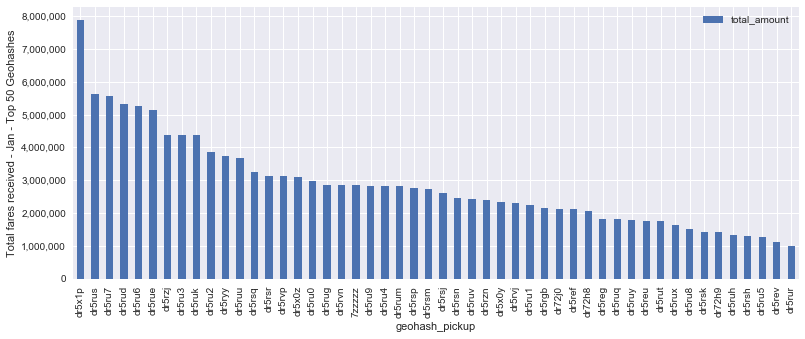

In [109]:
#plt.figure(figsize=(10,5))
ax = pickup_sum_fare[:50].plot(x='geohash_pickup',y='total_amount',kind='bar',figsize=(13,5))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total fares received - Jan - Top 50 Geohashes')

## Break up the day into five minute intervals( the time to traverse a geohash of ~610 meters).
- Aggregate all of the days together so that you have one 24 hour block
- For this 24 hour block, group by five minute periods
- For each period, take the geohash as the key and a list of tuples of ( average fares over the month, trip times in minutes)
- This gives an end result of the average fare and corresponding trip time and ration of fare/trip time for each geohash for a given ten minutes over each day in January

In [90]:
# Convert trip distance into minutes using the average speed of 10 MPH ( 8.6 in Manhattan + faster in the burbs)
def convert_miles_to_minutes_nyc(input_distance):
    """Convert MPH to minutes using aveage speed of 10 mph. Round to this nearest 5 minutes"""
    mph=10
    def myround(x, base=5):
        nearest_five = int(base * round(float(x)/base))
        if nearest_five ==0:
            return 5 ## shortest trip is five minutes
        else:
            return nearest_five
    minutes = input_distance /mph *60
    return myround(minutes)
    
taxi_yellowcab_df['trip_time_minutes'] = taxi_yellowcab_df.trip_distance.apply(lambda x: convert_miles_to_minutes_nyc(x))

In [49]:
# distribution of trip times
trip_minutes_grouped = taxi_yellowcab_df.groupby('trip_time_minutes').count()

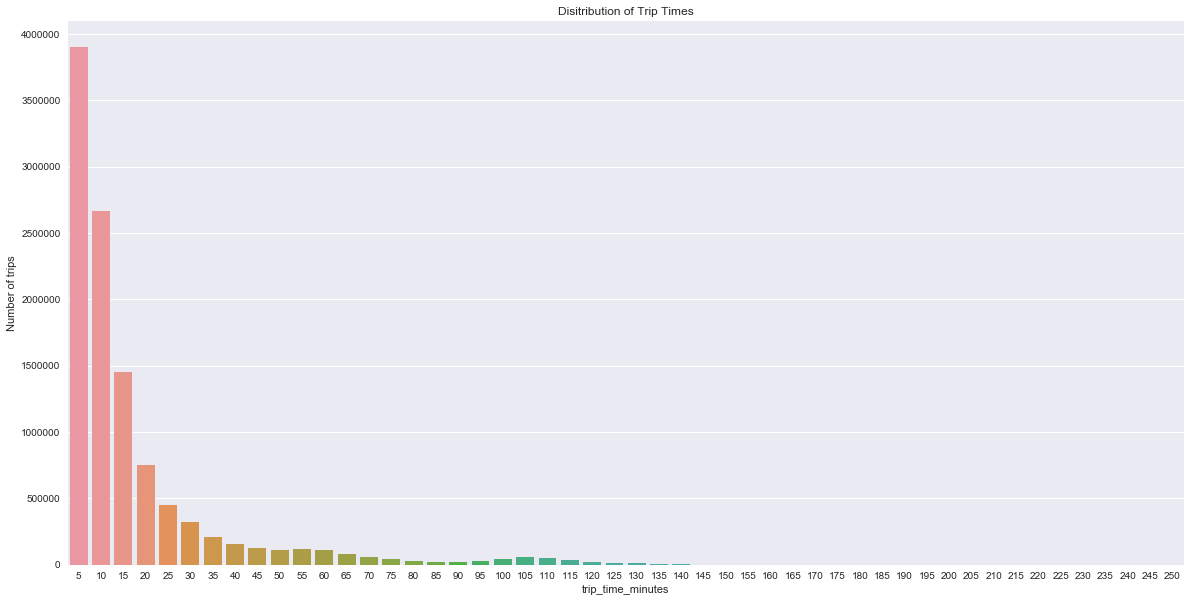

In [75]:
plt.figure(figsize=(20,10))
sns.barplot(x = trip_minutes_grouped['VendorID'].reset_index()['trip_time_minutes'][:50],
            y= trip_minutes_grouped['VendorID'].reset_index()['VendorID'][:50])
plt.ylabel('Number of trips')
plt.title('Disitribution of Trip Times')

In [87]:
taxi_yellowcab_df['trip_time_minutes'].head()

0     5
1    30
2    65
3    30
4    10
Name: trip_time_minutes, dtype: int64

In [91]:
# Only pull the columns we need 
average_fare_during_day = taxi_yellowcab_df.loc[:,('tpep_pickup_datetime','trip_time_minutes',
                            'tpep_dropoff_datetime','total_amount','geohash_dropoff','geohash_pickup','jan_day')]

In [92]:
average_fare_during_day.tpep_pickup_datetime = pd.to_datetime(average_fare_during_day.tpep_pickup_datetime)


In [93]:
average_fare_during_day.index = average_fare_during_day.tpep_pickup_datetime


In [94]:
average_fare_during_day.head()

,tpep_pickup_datetime,trip_time_minutes,tpep_dropoff_datetime,total_amount,geohash_dropoff,geohash_pickup,jan_day
tpep_pickup_datetime,,,,,,,
2016-01-01,2016-01-01,5,2016-01-01 00:00:00,8.8,dr5rsx,dr5rsr,1
2016-01-01,2016-01-01,30,2016-01-01 00:00:00,19.3,dr5rtk,dr5rsw,1
2016-01-01,2016-01-01,65,2016-01-01 00:00:00,34.3,dr72j1,dr5rkm,1
2016-01-01,2016-01-01,30,2016-01-01 00:00:00,17.3,dr5rkc,dr5rsh,1
2016-01-01,2016-01-01,10,2016-01-01 00:00:00,8.8,dr5rue,dr72hb,1


In [95]:
grouped_pickup_fares = average_fare_during_day.groupby(pd.TimeGrouper(freq='5Min')).apply(
    lambda x: x.groupby('geohash_pickup').mean())

In [96]:
grouped_pickup_fares  = grouped_pickup_fares.reset_index()

In [97]:
# groupby again only on minutes this time
grouped_pickup_fares['time'] = grouped_pickup_fares.tpep_pickup_datetime.apply(lambda x : x.time())

In [98]:
grouped_pickup_fares .head()

,tpep_pickup_datetime,geohash_pickup,trip_time_minutes,total_amount,jan_day,time
0,2016-01-01,7zzzzz,12.500000,13.050625,1.0,00:00:00
1,2016-01-01,dr5rec,55.000000,28.300000,1.0,00:00:00
2,2016-01-01,dr5ree,5.000000,20.800000,1.0,00:00:00
3,2016-01-01,dr5ref,20.833333,15.693333,1.0,00:00:00
4,2016-01-01,dr5reg,23.333333,18.533333,1.0,00:00:00


In [100]:
# change the trip time to be a factor of five again
def myround(x, base=5):
        nearest_five = int(base * round(float(x)/base))
        if nearest_five ==0:
            return 5 ## shortest trip is five minutes
        else:
            return nearest_five
grouped_pickup_fares.trip_time_minutes = grouped_pickup_fares.trip_time_minutes.apply(lambda x: myround(x))

In [101]:
average_fares_throughout_day_geohash = grouped_pickup_fares.groupby(
    ['time','geohash_pickup','jan_day','trip_time_minutes']).mean().reset_index()

In [102]:
average_fares_throughout_day_geohash['average_fare'] = average_fares_throughout_day_geohash['total_amount']
average_fares_throughout_day_geohash.drop('total_amount',inplace=True,axis=1)

In [187]:
## convert the string of time into an integer
def time_to_int(time):
    hour = str(time.hour)
    minutes = str(time.minute)
    if len(hour)==1:
        hour ='0'+hour
    if len(minutes)==1:
        minutes = '0'+minutes
    return int(hour+minutes)
average_fares_throughout_day_geohash.time = average_fares_throughout_day_geohash.time.apply(lambda x: time_to_int(x))

In [208]:
average_fares_throughout_day_geohash.time.tail() # midnight is now 0

982035    2355
982036    2355
982037    2355
982038    2355
982039    2355
Name: time, dtype: int64

In [205]:
# Turn this into a dictionary where the key is the time : key is the geohas : value is a list of a tuple of fares,
# time, fare divided by time
# on average for that day for that geohash 

time_geohash_fare_dict = defaultdict(lambda : defaultdict(list))

In [206]:
for row in average_fares_throughout_day_geohash.iterrows():
    # Create a dict of dict of a list of tuples - tuple is (fare, trip-minutes, fare/trip-minutes)

    time_geohash_fare_dict[row[1]['time']][row[1]['geohash_pickup']].append(
    (row[1]['average_fare'],row[1]['trip_time_minutes'],row[1]['average_fare']/(row[1]['trip_time_minutes']+.000000001)))


In [212]:
# test the dictionary # fare followed by time in minutes)
time_geohash_fare_dict[115]['7zzzzz']

[(19.62545454545454, 20, 0.9812727272236634),
 (10.66375, 15, 0.7109166666192722),
 (14.304800000000002, 20, 0.7152399999642381),
 (18.312499999999996, 30, 0.6104166666463193),
 (35.85, 15, 2.3899999998406667),
 (21.926250000000003, 20, 1.0963124999451845),
 (24.080000000000002, 10, 2.4079999997592),
 (15.987857142857147, 20, 0.7993928571028877),
 (19.24666666666667, 20, 0.9623333332852169),
 (14.967083333333337, 15, 0.9978055554890354),
 (28.507499999999997, 20, 1.425374999928731),
 (22.775000000000002, 30, 0.7591666666413612),
 (26.528333333333336, 25, 1.061133333290888),
 (13.094999999999999, 20, 0.6547499999672625),
 (23.794375000000002, 25, 0.951774999961929),
 (18.226666666666674, 25, 0.7290666666375043),
 (13.440454545454545, 15, 0.8960303029705676),
 (14.093636363636364, 15, 0.9395757575131192),
 (23.42333333333334, 15, 1.5615555554514522),
 (16.810000000000002, 25, 0.6723999999731041),
 (20.621000000000002, 20, 1.0310499999484477),
 (18.48166666666667, 20, 0.9240833332871293),

In [226]:
# test the dictionary and ensure that the fare and the time changes, fare followed by time in minutes
time_geohash_fare_dict[555]['7zzzzz']

[(48.87133333333332, 15, 3.258088888671682),
 (24.65, 40, 0.6162499999845937),
 (11.410000000000002, 10, 1.1409999998859002),
 (15.143333333333333, 25, 0.605733333309104),
 (20.418, 30, 0.6805999999773134),
 (11.894444444444442, 15, 0.7929629629100986),
 (17.953333333333333, 25, 0.7181333333046079),
 (14.90625, 20, 0.7453124999627344),
 (28.386666666666667, 40, 0.7096666666489251),
 (34.31333333333333, 60, 0.5718888888793574),
 (14.976666666666667, 20, 0.7488333332958916),
 (23.72142857142857, 25, 0.9488571428191885),
 (18.258888888888887, 30, 0.6086296296093419),
 (13.047999999999998, 15, 0.8698666666086754),
 (11.77, 15, 0.7846666666143555),
 (43.74333333333333, 15, 2.916222222027807),
 (74.3, 80, 0.9287499999883906),
 (59.379999999999995, 40, 1.4844999999628876),
 (9.227999999999998, 10, 0.9227999999077198),
 (21.27857142857143, 20, 1.063928571375375),
 (19.254, 25, 0.7701599999691936),
 (18.447000000000006, 25, 0.737879999970485),
 (29.793333333333337, 45, 0.6620740740593615),
 (28

## Index the geohashes to a number
## List of possible times

In [241]:
## get a list of unique geohashes
list_of_unique_geohashes = taxi_yellowcab_df.geohash_pickup.unique()
len(unique_geohashes)

3086

In [243]:
list_of_geohash_index  = defaultdict(int)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_geohash_index [hash_n] = idx

In [238]:
list_of_inverse_heohash_index = defaultdict(str)
for idx,hash_n in enumerate(unique_geohashes):
    list_of_inverse_heohash_index[idx] = hash_n

In [236]:
list_of_time_index = average_fares_throughout_day_geohash.time.unique()

In [237]:
list_of_time_index

array([   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,   50,
         55,  100,  105,  110,  115,  120,  125,  130,  135,  140,  145,
        150,  155,  200,  205,  210,  215,  220,  225,  230,  235,  240,
        245,  250,  255,  300,  305,  310,  315,  320,  325,  330,  335,
        340,  345,  350,  355,  400,  405,  410,  415,  420,  425,  430,
        435,  440,  445,  450,  455,  500,  505,  510,  515,  520,  525,
        530,  535,  540,  545,  550,  555,  600,  605,  610,  615,  620,
        625,  630,  635,  640,  645,  650,  655,  700,  705,  710,  715,
        720,  725,  730,  735,  740,  745,  750,  755,  800,  805,  810,
        815,  820,  825,  830,  835,  840,  845,  850,  855,  900,  905,
        910,  915,  920,  925,  930,  935,  940,  945,  950,  955, 1000,
       1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055,
       1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150,
       1155, 1200, 1205, 1210, 1215, 1220, 1225, 12

# Use an Actor Critic Model
- https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html

In [75]:
def create_actor_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size])  
        h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
        h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)
        Steering = Dense(1,activation='tanh',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Acceleration = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Brake = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        V = merge([Steering,Acceleration,Brake],mode='concat')          
        model = Model(input=S,output=V)
        print("We finished building the model")
        return model, model.trainable_weights, S

In [41]:
## Actor
HIDDEN1_UNITS=10
HIDDEN2_UNITS=20
state_size=5
print("Now we build the model")
S = Input(shape=[state_size])
h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)

Steering = Dense(1,activation='tanh')(h1)   
Acceleration = Dense(1,activation='sigmoid')(h1)   
Brake = Dense(1,activation='sigmoid')(h1)   
V = Concatenate([Steering,Acceleration,Brake])

model = Model(inputs=S,output=[Steering,Acceleration,Brake])
model.summary()
print("We finished building the model")


Now we build the model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
dense_75 (Dense)                 (None, 10)            60                                           
____________________________________________________________________________________________________
dense_76 (Dense)                 (None, 20)            220                                          
____________________________________________________________________________________________________
dense_77 (Dense)                 (None, 1)             21                                           
____________________________________________________________________

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  '` call to the Keras 2 API: ' + signature)


In [50]:
## Critic
action_dim = 100
S = Input(shape=[state_size])
A = Input(shape=[action_dim],name='action2')    
w1 = Dense(HIDDEN1_UNITS, activation='relu')(S)
a1 = Dense(HIDDEN2_UNITS, activation='linear')(A)
h1 = Dense(HIDDEN2_UNITS, activation='linear')(w1)
h2 = Add(h1,a1)    
h3 = Dense(HIDDEN2_UNITS, activation='relu')(h2)
V = Dense(action_dim,activation='linear')(h3) 

model = Concatenate(input=[S,A],output=V)

adam = Adam(lr=self.LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)
print("We finished building the model")

TypeError: __init__() takes 1 positional argument but 3 were given

In [135]:
# parameters
GAME = 'bird' # the name of the game being played for log files
CONFIG = 'nothreshold'
ACTIONS = 9 # number of valid actions
GAMMA = 0.99 # decay rate of past observations
OBSERVATION = 3200. # timesteps to observe before training
EXPLORE = 3000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4

In [218]:
##define some test inputs , time, state
X = np.array([[10,2]])

In [281]:
##Define a simple model where the output is a softmax probability over the eight states
# Inputs will be the time, current geohash-index ()
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
model_simple = Sequential()
model_simple.add(Dense(100, activation='relu', input_shape= (2,)))
model_simple.add(Dense(9, activation='softmax')) ## predict which geohash to move to next
adam = Adam(lr=LEARNING_RATE)
model_simple.compile(loss='mse',optimizer=adam)
model_simple.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 909       
Total params: 1,209.0
Trainable params: 1,209
Non-trainable params: 0.0
_________________________________________________________________


In [282]:
model_simple.predict(X)

array([[ 0.06836795,  0.02239234,  0.01410827,  0.01209796,  0.35565951,
         0.2706784 ,  0.15476888,  0.04057044,  0.06135627]], dtype=float32)

In [256]:
list_of_geohash_index[np.random.choice(list_of_unique_geohashes)] # index of geohash

770

In [259]:
np.random.choice(list_of_time_index) # time

1410

In [271]:
np.array([[np.random.choice(list_of_time_index),
                     list_of_geohash_index[np.random.choice(list_of_unique_geohashes)]]])
    

array([[ 605, 2775]])

In [278]:
random.randrange(ACTIONS)

8

In [319]:
def trainNetworkNeuralNetworkTaxicab(model, list_of_unique_geohashes):
    # Code adapted from https://github.com/yanpanlau/Keras-FlappyBird/blob/master/qlearn.py
    ## pick a random state and time to start at
    
    # store the previous observations in replay memory
    D = deque()
    
    # get the first state by randomlly choosing a geohash to start at and random time to start at
    starting_geohash = np.random.choice(list_of_unique_geohashes)
    s_t = np.array([[np.random.choice(list_of_time_index),
                     list_of_geohash_index[starting_geohash]]])
    print(s_t,'starting time and geohash index')
    args = {'None':0}
    try:
        args['mode'] == 'Run' ## don't need this
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    except KeyError:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON
        
    #start your observations
    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        print(t, ' t')
        #choose a random action action epsilon greedy
        if t % FRAME_PER_ACTION == 0: ## will always choose this if frame per action is 1
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS) # Randomlly choose another geohash to go to
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input the time followed by the geohash index
                max_Q = np.argmax(q)  # find the position of the highest probability (which direction to go in)
                action_index = max_Q
                a_t[max_Q] = 1
                
        #We reduced the epsilon gradually to take more random actions 
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
            
        #run the selected action and observed next state and reward
        # We need to find the neighbors to the geohash that we started at
        
#         x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        

#         x_t1 = skimage.color.rgb2gray(x_t1_colored)
#         x_t1 = skimage.transform.resize(x_t1,(80,80))
#         x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))

#         x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
#         s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

#         # store the transition in D
#         D.append((s_t, action_index, r_t, s_t1, terminal))
#         if len(D) > REPLAY_MEMORY:
#             D.popleft()

            
        #gh.neighbors()
        print(a_t,'a_t')
        print(output_predictions_to_direction[np.argmax(a_t)],'direction to take')
        print(action_index,'action index')
        break

In [325]:
trainNetworkNeuralNetworkTaxicab(model_simple, list_of_unique_geohashes)

[[2105 2233]] starting time and geohash index
0  t
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.] a_t
e direction to take
5 action index


In [ ]:
def trainNetwork(model,args):
    # open up a game state to communicate with emulator 
    game_state = game.GameState()

    # store the previous observations in replay memory
    D = deque()

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)

    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t,(80,80))
    x_t = skimage.exposure.rescale_intensity(x_t,out_range=(0,255))

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    #print (s_t.shape)

    #In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*80*80*4
    
    if args['mode'] == 'Run': ## don't need this
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON

    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[max_Q] = 1

        #We reduced the epsilon gradually to take more random actions 
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        #run the selected action and observed next state and reward
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        

        x_t1 = skimage.color.rgb2gray(x_t1_colored)
        x_t1 = skimage.transform.resize(x_t1,(80,80))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))

        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE:
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)



            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 80, 80, 4
            print (inputs.shape)
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]
                state_t1 = minibatch[i][3]
                terminal = minibatch[i][4]
                # if terminated, only equals reward

                inputs[i:i + 1] = state_t    #I saved down s_t

                targets[i] = model.predict(state_t)  # Hitting each buttom probability
                Q_sa = model.predict(state_t1)

                if terminal:
                    targets[i, action_t] = reward_t
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            # targets2 = normalize(targets)
            loss += model.train_on_batch(inputs, targets)

        s_t = s_t1
        t = t + 1

        # save progress every 10000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            model.save_weights("model.h5", overwrite=True)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")